In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import editdistance

# ---------- Config ----------
DATA_FOLDER = "data/LJSpeech-1.1/wavs"      # твій шлях до .wav
METADATA_PATH = "data/LJSpeech-1.1/metadata.csv"
BATCH_SIZE = 4
EPOCHS = 30
LR = 5e-5
N_MELS = 80
MAX_MEL_LEN = 32
MAX_TEXT_LEN = 16
MAX_SAMPLES = 500    # For speedup
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(SEED)
torch.manual_seed(SEED)

C:\Users\user\PycharmProjects\Voice\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---------- Dataset ----------
class RealTTSDataset(Dataset):
    def __init__(self, data_folder, metadata_path, tokenizer, n_mels=80, max_mel_len=32, max_text_len=16, max_samples=500):
        self.data_folder = data_folder
        self.tokenizer = tokenizer
        self.n_mels = n_mels
        self.max_mel_len = max_mel_len
        self.max_text_len = max_text_len
        self.items = []
        with open(metadata_path, encoding='utf-8') as f:
            for i, line in enumerate(f):
                parts = line.strip().split("|")
                if len(parts) < 2:
                    continue
                audio_file, text = parts[0], parts[1]
                wav_path = os.path.join(data_folder, audio_file + ".wav")
                if os.path.exists(wav_path):
                    self.items.append((wav_path, text))
                if len(self.items) >= max_samples:
                    break

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        wav_path, text = self.items[idx]
        # Load audio, to mels
        y, sr = librosa.load(wav_path, sr=22050)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels, hop_length=256)
        mel = librosa.power_to_db(mel).astype(np.float32)
        # Pad/trim mel
        if mel.shape[1] < self.max_mel_len:
            pad_width = self.max_mel_len - mel.shape[1]
            mel = np.pad(mel, ((0,0),(0, pad_width)), mode='constant')
        else:
            mel = mel[:, :self.max_mel_len]
        # Tokenize
        tokens = self.tokenizer(text, return_tensors="pt", padding='max_length',
                                max_length=self.max_text_len, truncation=True)
        return {
            "input_ids": tokens.input_ids.squeeze(0),
            "attention_mask": tokens.attention_mask.squeeze(0),
            "mel": torch.tensor(mel.T, dtype=torch.float32)   # [max_mel_len, n_mels]
        }

# ---------- Model ----------
class GPT2TTSModel(nn.Module):
    def __init__(self, out_dim=80):
        super().__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        self.out_proj = nn.Linear(self.gpt2.config.n_embd, out_dim)
    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]   # [B, L, H]
        mel_out = self.out_proj(hidden_states)      # [B, L, n_mels]
        return mel_out

In [3]:
# ---------- Training ----------
def train(model, loader, optimizer, criterion, device):
    model.train()
    for epoch in range(EPOCHS):
        losses = []
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            mel_target = batch["mel"].to(device)  # [B, MAX_MEL_LEN, N_MELS]

            optimizer.zero_grad()
            mel_pred = model(input_ids, attention_mask)  # [B, L, N_MELS]

            # ALIGN by truncating or padding
            if mel_pred.shape[1] > mel_target.shape[1]:
                mel_pred = mel_pred[:, :mel_target.shape[1], :]
            elif mel_pred.shape[1] < mel_target.shape[1]:
                pad_len = mel_target.shape[1] - mel_pred.shape[1]
                mel_pred = torch.cat(
                    [mel_pred, torch.zeros(mel_pred.size(0), pad_len, mel_pred.size(2), device=mel_pred.device)],
                    dim=1
                )
            # Now mel_pred and mel_target have same shape [B, MAX_MEL_LEN, N_MELS]
            loss = criterion(mel_pred, mel_target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {np.mean(losses):.4f}")

# ---------- MEL inference ----------
def infer_mel(model, tokenizer, text, device, max_len=MAX_MEL_LEN):
    model.eval()
    with torch.no_grad():
        tokens = tokenizer(text, return_tensors="pt", padding='max_length',
                           max_length=MAX_TEXT_LEN, truncation=True)
        input_ids = tokens.input_ids.to(device)
        attention_mask = tokens.attention_mask.to(device)
        mel_out = model(input_ids, attention_mask)  # [1, L, n_mels]
        mel_out = mel_out[0].cpu().numpy().T        # [n_mels, L]
        return mel_out[:, :max_len]

# ---------- MEL -> Audio ----------
def mel_to_audio(mel, sr=22050, n_fft=1024, hop_length=256):
    # Inverse dB
    mel = librosa.db_to_power(mel)
    audio = librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return audio

# ---------- CER ----------
def cer(s1, s2):
    s1, s2 = s1.replace(' ', ''), s2.replace(' ', '')
    return editdistance.eval(s1, s2) / max(1, len(s2))

# ---------- ASR pipeline (Whisper) ----------
asr = pipeline("automatic-speech-recognition", model="openai/whisper-tiny") # add device=0 for GPU

def get_asr_text(audio, sr=22050):
    temp_wav = "temp_gen.wav"
    sf.write(temp_wav, audio, sr)
    result = asr(temp_wav)
    return result['text'].strip()

# ---------- Plot MEL ----------
def plot_mel(mel, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel, aspect="auto", origin="lower")
    plt.title(title)
    plt.xlabel("Frames")
    plt.ylabel("Mel bins")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

Device set to use cuda:0


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Epoch 1/30 - Loss: 594.3337
Epoch 2/30 - Loss: 473.6890
Epoch 3/30 - Loss: 433.8191
Epoch 4/30 - Loss: 422.4576
Epoch 5/30 - Loss: 418.8696
Epoch 6/30 - Loss: 416.4113
Epoch 7/30 - Loss: 412.7076
Epoch 8/30 - Loss: 410.6241
Epoch 9/30 - Loss: 408.2580
Epoch 10/30 - Loss: 405.7374
Epoch 11/30 - Loss: 404.2414
Epoch 12/30 - Loss: 401.2063
Epoch 13/30 - Loss: 398.3660
Epoch 14/30 - Loss: 395.9790
Epoch 15/30 - Loss: 392.9986
Epoch 16/30 - Loss: 390.5239
Epoch 17/30 - Loss: 386.1571
Epoch 18/30 - Loss: 382.9736
Epoch 19/30 - Loss: 379.7586
Epoch 20/30 - Loss: 375.9957
Epoch 21/30 - Loss: 374.8784
Epoch 22/30 - Loss: 373.1648
Epoch 23/30 - Loss: 370.9058
Epoch 24/30 - Loss: 369.7361
Epoch 25/30 - Loss: 368.5228
Epoch 26/30 - Loss: 367.1029
Epoch 27/30 - Loss: 366.0060
Epoch 28/30 - Loss: 364.4719
Epoch 29/30 - Loss: 363.6755
Epoch 30/30 - Loss: 362.6411


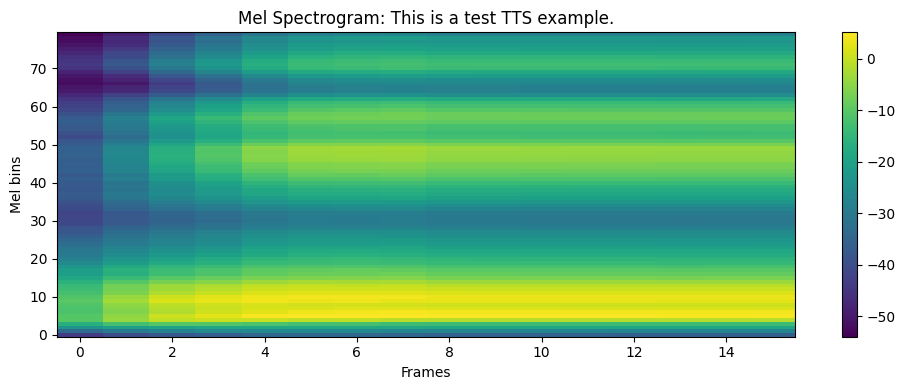

C:\Users\user\PycharmProjects\Voice\.venv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Target: This is a test TTS example.
Recognized: Okay.
CER: 0.9091


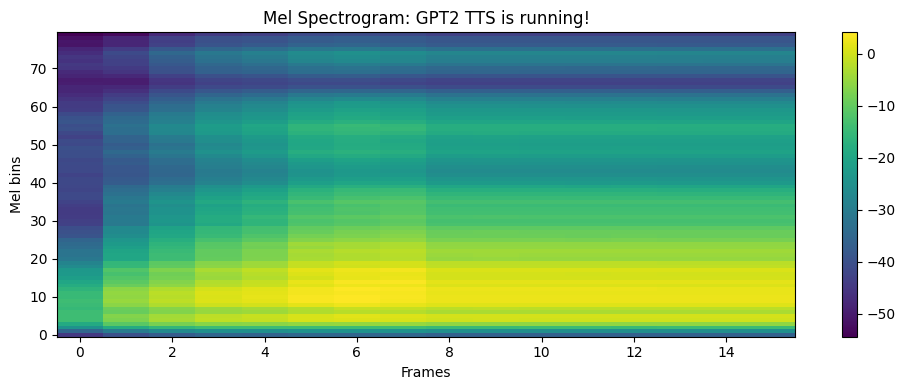

Target: GPT2 TTS is running!
Recognized: Thank you very much.
CER: 1.0000


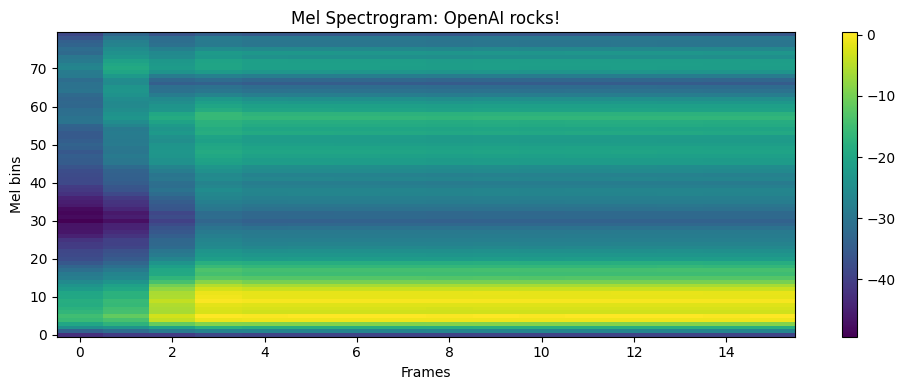

Target: OpenAI rocks!
Recognized: Thank you.
CER: 0.8333


In [4]:
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    dataset = RealTTSDataset(DATA_FOLDER, METADATA_PATH, tokenizer, n_mels=N_MELS, max_mel_len=MAX_MEL_LEN,
                             max_text_len=MAX_TEXT_LEN, max_samples=MAX_SAMPLES)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = GPT2TTSModel(out_dim=N_MELS).to(DEVICE)
    model.gpt2.resize_token_embeddings(len(tokenizer))
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    train(model, loader, optimizer, criterion, DEVICE)

    # ---- EVALUATION ----
    texts = [
        "This is a test TTS example.",
        "GPT2 TTS is running!",
        "OpenAI rocks!"
    ]
    for text in texts:
        mel = infer_mel(model, tokenizer, text, DEVICE)
        plot_mel(mel, title=f"Mel Spectrogram: {text}")
        audio = mel_to_audio(mel)
        recognized = get_asr_text(audio)
        val_cer = cer(recognized.lower(), text.lower())
        print(f"Target: {text}")
        print(f"Recognized: {recognized}")
        print(f"CER: {val_cer:.4f}")
        print("="*50)